In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:

df=pd.read_csv("C:\\Users\\sabbi\\Dropbox\\NLP\\input_data\\complaints-2021-03-29_17_28.csv")
df.head()
#df['Product'].unique() # credit card data only




,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,04/15/16,Credit card,None,Application processing delay,None,NaN,None,FIRSTBANK PUERTO RICO,PR,00987,None,Consent not provided,Web,05/12/16,Closed,Yes,Yes,1881274
1,12/16/15,Credit card,None,Sale of account,None,NaN,None,HSBC NORTH AMERICA HOLDINGS INC.,NY,148XX,None,NaN,Phone,12/17/15,Closed with explanation,Yes,No,1705689
2,06/11/12,Credit card,None,Customer service / Customer relations,None,NaN,None,JPMORGAN CHASE & CO.,FL,33029,None,NaN,Web,06/13/12,Closed with explanation,Yes,Yes,99187
3,01/25/14,Credit card,None,Closing/Cancelling account,None,NaN,None,HSBC NORTH AMERICA HOLDINGS INC.,MD,212XX,None,NaN,Web,01/24/14,Closed with explanation,Yes,No,683347
4,03/23/15,Credit card,None,Identity theft / Fraud / Embezzlement,None,NaN,None,CAPITAL ONE FINANCIAL CORPORATION,FL,33324,Older American,NaN,Phone,03/24/15,Closed with explanation,Yes,Yes,1295234


In [110]:
#keeps only the relevant columns

df=df[['Consumer disputed?','Consumer complaint narrative']]
df.rename({'Consumer disputed?':'Dispute', 'Consumer complaint narrative': 'Narrative'},axis=1,inplace=True)
df.isnull().values.any()
df=df.dropna()
df.reset_index(drop=True, inplace=True)
df.head()


,Dispute,Narrative
0,No,My discover card statement was automatically d...
1,No,"Earlier this month, I set up an electronic pay..."
2,Yes,"XXXX XXXX, 2016 To Whom It May Concern : I 'm ..."
3,Yes,I have rented a car XXXX and paid the rental a...
4,No,I was shocked when I reviewed my credit report...


[0.23, 0.77]


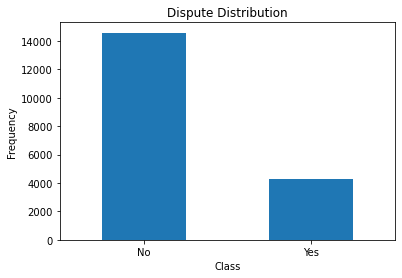

In [111]:
#checks class balance

count_classes=pd.value_counts(df['Dispute'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Dispute Distribution")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency")

class_proportion = [round(sum(df['Dispute']=='Yes')/(sum(df['Dispute']=='Yes') + sum(df['Dispute']=='No')),2), round(sum(df['Dispute']=='No')/(sum(df['Dispute']=='Yes') + sum(df['Dispute']=='No')),2) ]
print(class_proportion)

# Yes_data=df[df['Dispute']=='Yes']
# Yes_data.reset_index(drop=True, inplace=True)
# No_data=df[df['Dispute']=='No']
# No_data.reset_index(drop=True, inplace=True)


In [112]:
# sample 1000 rows from the total data set for train
train_data = df.sample(n=1000,replace=False)
train_data.reset_index(drop=True, inplace=True)
class_proportion = [round(sum(train_data['Dispute']=='Yes')/(sum(train_data['Dispute']=='Yes') + sum(train_data['Dispute']=='No')),2), round(sum(train_data['Dispute']=='No')/(sum(train_data['Dispute']=='Yes') + sum(train_data['Dispute']=='No')),2) ]
print(class_proportion)


[0.23, 0.77]


In [113]:
#Renames the vars

X=train_data.drop('Dispute', axis=1)
y=train_data['Dispute'].map({'Yes':1, 'No':0})

messages=X.copy()

#printing the 4th complaint
print(messages['Narrative'][3]) #printing the first complaint




Chase credit card services contacted my place of work, thus jeopardizing my employment. I did not give my employers number nor the written consent to contact me at my workplace. I asked them to stop immediately as this is a form of harassment. They have also contacted me repeatedly at my mobile and work mobile phone during my working hours, at inconvenient times.


In [114]:
import nltk
import re
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()


In [115]:
corpus=[]

contractions=re.compile(r"'|-|\"") #ref: Matt Taddy BDS
symbols=re.compile(r'(\W+)', re.U)
singles=re.compile(r'(\s\S\s)', re.I | re.U)
seps=re.compile(r'\s+')
special=['XXXX','xxxx','XX','xx','XXX','xxx','XXXXX','xxxxx']
pattern= '['+''.join(special)+']' #ref:https://thispointer.com/python-remove-characters-from-string-by-regex-4-other-ways/


In [116]:
#get tensorflow
#https://www.freecodecamp.org/news/install-tensorflow-and-keras-using-anaconda-navigator-without-command-line/

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense 

for i in range (0, len(messages)):
    #print(i)
    complaint=re.sub('[^a-zA-Z]',' ', messages['Narrative'][i])
    complaint=complaint.lower()
    #complaint=contractions.sub('', complaint)
    #complaint=symbols.sub(r' \1', complaint)
    #complaint=singles.sub(' ', complaint)
    #complaint=seps.sub(' ', complaint)
    complaint=re.sub(pattern,'', complaint)
    complaint=complaint.split()
     
    complaint=[ps.stem(word) for word in complaint if not word in stopwords.words('english')]
    complaint=' '.join(complaint)
    corpus.append(complaint)
 

In [117]:
#printing the 10th complaint
print(corpus[4]) #printing the first complaint
#len(corpus[4])

write agenc hope help disput charg made got contact unsolicit phone call paid total aarp visa card promis servic never render start call say need servic order onlin busi make money receiv noth day inform day tri disput decid take chanc sinc got involv mess lost close pay fraudul compani ignor call


In [166]:
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus]  # How does voc_size work here??
print(onehot_repr[2])
print(len(onehot_repr[2]))

[2706, 4095, 4534, 4278, 4695, 3299, 4095, 3372, 2034, 3446, 4227, 874, 135, 936, 3515, 4540, 2263, 1187, 1773, 288, 135, 4705, 3272, 880, 432, 1961, 4105, 135, 2196, 1961, 1046, 3515, 44, 1368, 135, 3272, 4661, 2760, 2661, 2563, 4105, 2085, 2623]
43


In [167]:
sent_length=100
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
#print(embedded_docs[5:10,1600:1700])

In [168]:

## Creating model
embedding_vector_features=40 # What does this number do? Does it 
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 40)           200000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [169]:

import numpy as np
X_final=np.array(embedded_docs)

y_final=np.array(y)

#X_final.shape
#y_final.shape


In [170]:

from imblearn.under_sampling import NearMiss
# alpha01 = no of minority class / no of majority class
# alpha01 = 1
nm=NearMiss(sampling_strategy='majority')

X_res, y_res=nm.fit_resample(X_final, y_final)

#print(X_res.shape)
#print(y_res.shape)
class_proportion = [sum(y_res==1)/len(y_res), sum(y_res==0)/len(y_res)]
print(class_proportion)

[0.5, 0.5]


In [171]:

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_final)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42)



Original dataset shape Counter({0: 765, 1: 235})
Resampled dataset shape Counter({0: 235, 1: 235})


In [172]:
### Finally Training
performance=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)
y_pred=model.predict_classes(X_test)


Train on 352 samples, validate on 118 samples
Epoch 1/20
352/352 [==============================] - 1s 4ms/sample - loss: 0.6929 - acc: 0.5199 - val_loss: 0.6928 - val_acc: 0.5508
Epoch 2/20
352/352 [==============================] - 1s 2ms/sample - loss: 0.6886 - acc: 0.7443 - val_loss: 0.6888 - val_acc: 0.6610
Epoch 3/20
352/352 [==============================] - 1s 2ms/sample - loss: 0.6647 - acc: 0.8381 - val_loss: 0.5807 - val_acc: 0.7627
Epoch 4/20
352/352 [==============================] - 1s 2ms/sample - loss: 0.5462 - acc: 0.7898 - val_loss: 0.4906 - val_acc: 0.8136
Epoch 5/20
352/352 [==============================] - 1s 2ms/sample - loss: 0.4193 - acc: 0.8466 - val_loss: 0.3949 - val_acc: 0.8136
Epoch 6/20
352/352 [==============================] - 1s 2ms/sample - loss: 0.3875 - acc: 0.8295 - val_loss: 0.3976 - val_acc: 0.8220
Epoch 7/20
352/352 [==============================] - 1s 2ms/sample - loss: 0.3227 - acc: 0.8807 - val_loss: 0.3851 - val_acc: 0.8305
Epoch 8/20
352/3

In [173]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)


array([[51, 11],
       [12, 44]], dtype=int64)

In [174]:

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))
print(len(performance.history['acc']))
print(len(performance.history['val_acc']))

0.8050847457627118
20
20


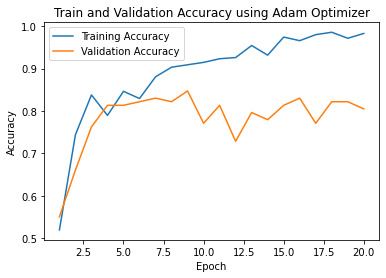

In [175]:

# Plot accuracy per epoch
plt.plot(range(1,len(performance.history['acc'])+1), performance.history['acc'], label='Training Accuracy') 
plt.plot(range(1,len(performance.history['val_acc'])+1), performance.history['val_acc'], label='Validation Accuracy')
#plt.axis([1, 2, 0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using Adam Optimizer')
plt.legend()
plt.show()




In [165]:

performance.history['acc']

[0.9488636,
 0.9744318,
 0.97727275,
 0.98579544,
 0.98295456,
 0.96022725,
 0.94034094,
 0.9801136,
 0.96875,
 0.9886364,
 0.9886364,
 0.9886364,
 0.98579544,
 0.9886364,
 0.99147725,
 0.99147725,
 0.99147725,
 0.99147725,
 0.99147725,
 0.99147725]

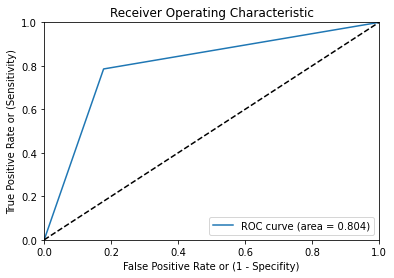

In [176]:

#plots ROC
#Ref:https://stackoverflow.com/questions/34564830/roc-curve-with-sklearn-python
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


In [ ]:

# from tensorflow.keras.layers import Dropout
# ## Creating model
# embedding_vector_features=40
# model=Sequential()
# model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
# model.add(Dropout(0.3))
# model.add(LSTM(100))
# model.add(Dropout(0.3))
# model.add(Dense(1,activation='sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:

# expe=messages.head()  

# for i in range (0, len(expe)):
#     print(i)
#     complaint=re.sub('[^a-zA-Z]',' ', expe['Narrative'][3])
#     #complaint=expe['Narrative'][i].lower()
#     #complaint=contractions.sub('', complaint)
#     #complaint=symbols.sub(r' \1', complaint)
#     #complaint=singles.sub(' ', complaint)
#     #complaint=seps.sub(' ', complaint)
#     complaint=re.sub(pattern,'', complaint)
    
        
#     #complaint= complaint.lower()
#     complaint=complaint.split()
     
#     complaint=[ps.stem(word) for word in complaint if not word in stopwords.words('english')]
#     complaint=' '.join(complaint)
#     corpus.append(complaint)
